In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import os

# 设备配置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [2]:
# 数据预处理类
class CMAPSSDataset(Dataset):
    def __init__(self, data_path, sequence_length=30, dataset='FD002', mode='train'):
        """
        初始化C-MAPSS数据集
        :param data_path: 数据集路径
        :param sequence_length: 时间序列长度
        :param dataset: 数据集名称 (FD001-FD004)
        :param mode: 'train'或'test'
        """
        self.mode = mode

        # 读取数据
        if mode == 'train':
            data = pd.read_csv(f'{data_path}/train_{dataset}.txt', sep=' ', header=None)
            data.drop(columns=[26, 27], inplace=True)
            data.columns = ['id', 'cycle'] + [f'sensor_{i}' for i in range(1, 22)] + ['setting1', 'setting2', 'setting3']
            
            # 计算RUL
            def add_rul(df):
                max_cycle = df['cycle'].max()
                df['RUL'] = max_cycle - df['cycle']
                return df
            
            data = data.groupby('id').apply(add_rul)
        else:
            data = pd.read_csv(f'{data_path}/test_{dataset}.txt', sep=' ', header=None)
            data.drop(columns=[26, 27], inplace=True)
            data.columns = ['id', 'cycle'] + [f'sensor_{i}' for i in range(1, 22)] + ['setting1', 'setting2', 'setting3']
            
            # 读取RUL标签并计算
            RUL = pd.read_csv(f'{data_path}/RUL_{dataset}.txt', sep=' ', header=None)
            RUL.drop(columns=[1], inplace=True)
            
            def add_rul(df):
                max_cycle = df['cycle'].max() + RUL.iloc[df['id'].iloc[0]-1, 0]
                df['RUL'] = max_cycle - df['cycle']
                return df
            
            data = data.groupby('id').apply(add_rul)
        
        # 归一化处理
        self.scaler = MinMaxScaler()
        sensor_cols = [col for col in data.columns if 'sensor' in col or 'setting' in col]
        
        if mode == 'train':
            data[sensor_cols] = self.scaler.fit_transform(data[sensor_cols])
        else:
            # 测试集使用训练集的scaler
            train_data = pd.read_csv(f'{data_path}/train_{dataset}.txt', sep=' ', header=None)
            train_data.drop(columns=[26, 27], inplace=True)
            train_data.columns = ['id', 'cycle'] + [f'sensor_{i}' for i in range(1, 22)] + ['setting1', 'setting2', 'setting3']
            train_sensor_cols = [col for col in train_data.columns if 'sensor' in col or 'setting' in col]
            self.scaler.fit(train_data[train_sensor_cols])
            data[sensor_cols] = self.scaler.transform(data[sensor_cols])
        
        # 创建序列数据
        self.sequences = []
        self.labels = []
        self.engine_ids = []
        
        for engine_id in data['id'].unique():
            engine_data = data[data['id'] == engine_id]
            
            if mode == 'train':
                # 训练集: 创建滑动窗口
                for i in range(len(engine_data) - sequence_length + 1):
                    sequence = engine_data.iloc[i:i+sequence_length][sensor_cols].values
                    label = engine_data.iloc[i+sequence_length-1]['RUL']
                    self.sequences.append(sequence)
                    self.labels.append(label)
                    self.engine_ids.append(engine_id)
            else:
                # 测试集: 只取最后sequence_length个时间步
                if len(engine_data) >= sequence_length:
                    sequence = engine_data.iloc[-sequence_length:][sensor_cols].values
                else:
                    # 如果长度不足，用0填充前面
                    padding = np.zeros((sequence_length - len(engine_data), len(sensor_cols)))
                    sequence = np.vstack([padding, engine_data[sensor_cols].values])
                
                label = engine_data.iloc[-1]['RUL']
                self.sequences.append(sequence)
                self.labels.append(label)
                self.engine_ids.append(engine_id)
        
        self.sequences = np.array(self.sequences, dtype=np.float32)
        self.labels = np.array(self.labels, dtype=np.float32)
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        if self.mode == 'test':
            return torch.tensor(self.sequences[idx]), torch.tensor(self.labels[idx]), self.engine_ids[idx]
        else:
            return torch.tensor(self.sequences[idx]), torch.tensor(self.labels[idx])

In [3]:
# 定义Conv1D+LSTM模型
class ConvLSTMModel(nn.Module):
    def __init__(self, input_size, seq_length, hidden_size=64, num_layers=2, output_size=1):
        super(ConvLSTMModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool = nn.MaxPool1d(kernel_size=2)
        
        self.lstm = nn.LSTM(input_size=128, hidden_size=hidden_size, 
                           num_layers=num_layers, batch_first=True)
        
        self.fc1 = nn.Linear(hidden_size, 32)
        self.fc2 = nn.Linear(32, output_size)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        # 输入x形状: (batch_size, seq_length, input_size)
        # 需要转换为 (batch_size, input_size, seq_length) 用于Conv1D
        x = x.permute(0, 2, 1)
        
        # CNN部分
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        
        # 转换回 (batch_size, seq_length, features) 用于LSTM
        x = x.permute(0, 2, 1)
        
        # LSTM部分
        lstm_out, _ = self.lstm(x)
        # 只取最后一个时间步的输出
        lstm_out = lstm_out[:, -1, :]
        
        # 全连接层
        x = self.relu(self.fc1(lstm_out))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x


In [4]:
# 自定义RMSE损失函数
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self, yhat, y):
        loss = torch.sqrt(self.mse(yhat, y) + self.eps)
        return loss


In [5]:
# 训练函数
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50):
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        # 验证阶段
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels)
                val_loss += loss.item() * inputs.size(0)
        
        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    # 绘制损失曲线
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss (RMSE)')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE Loss')
    plt.legend()
    plt.show()
    
    return model


以下是主程序部分

In [ ]:
# 参数设置
data_path = './CMAPSSData'  # 修改为你的数据集路径
dataset = 'FD001'  # 可以选择FD001-FD004
sequence_length = 75
batch_size = 64
learning_rate = 0.001
num_epochs = 30
input_size = 24  # 21个传感器 + 3个设置参数
hidden_size = 128
num_layers = 2

In [7]:
# 1. 数据准备
print("Preparing data...")
train_dataset = CMAPSSDataset(data_path, sequence_length, dataset, mode='train')

# 划分训练集和验证集
train_idx, val_idx = train_test_split(range(len(train_dataset)), test_size=0.2, random_state=42)
train_subset = torch.utils.data.Subset(train_dataset, train_idx)
val_subset = torch.utils.data.Subset(train_dataset, val_idx)

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)


Preparing data...


C:\Users\z004jdrj\AppData\Local\Temp\ipykernel_33932\764335773.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('id').apply(add_rul)


In [8]:
# 2. 模型初始化
print("Initializing model...")
model = ConvLSTMModel(input_size, sequence_length, hidden_size, num_layers).to(device)

Initializing model...


In [9]:
# 3. 训练配置
criterion = RMSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


Training model...
Epoch 1/30, Train Loss: 63.5297, Val Loss: 52.1169
Epoch 2/30, Train Loss: 52.4225, Val Loss: 52.1104
Epoch 3/30, Train Loss: 52.3407, Val Loss: 52.1348
Epoch 4/30, Train Loss: 52.4113, Val Loss: 52.3198
Epoch 5/30, Train Loss: 30.3350, Val Loss: 23.7578
Epoch 6/30, Train Loss: 22.3457, Val Loss: 17.4098
Epoch 7/30, Train Loss: 18.8028, Val Loss: 15.6954
Epoch 8/30, Train Loss: 17.1238, Val Loss: 16.4403
Epoch 9/30, Train Loss: 15.1691, Val Loss: 11.2560
Epoch 10/30, Train Loss: 15.2011, Val Loss: 10.9326
Epoch 11/30, Train Loss: 14.1348, Val Loss: 9.0137
Epoch 12/30, Train Loss: 13.7014, Val Loss: 10.3892
Epoch 13/30, Train Loss: 13.1319, Val Loss: 12.9531
Epoch 14/30, Train Loss: 13.1045, Val Loss: 13.2387
Epoch 15/30, Train Loss: 12.3106, Val Loss: 9.9212
Epoch 16/30, Train Loss: 12.7842, Val Loss: 9.3491
Epoch 17/30, Train Loss: 11.9183, Val Loss: 9.0814
Epoch 18/30, Train Loss: 12.1366, Val Loss: 12.5198
Epoch 19/30, Train Loss: 11.8925, Val Loss: 8.2767
Epoch 20

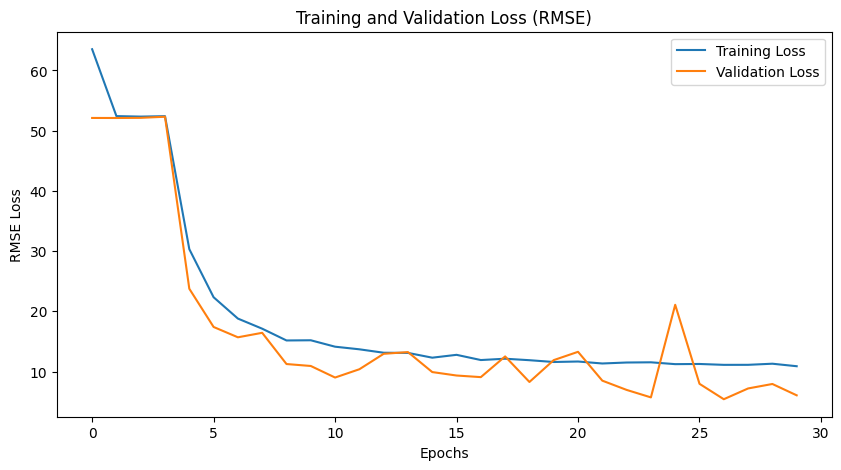

Model saved to models/conv1d_lstm_FD001.pth


In [10]:
# 4. 模型训练
print("Training model...")
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

# 保存模型
os.makedirs('models', exist_ok=True)
model_path = f'models/conv1d_lstm_{dataset}.pth'
torch.save(trained_model.state_dict(), model_path)
print(f"Model saved to {model_path}")


In [11]:
# 5. 测试评估
print("Evaluating on test set...")

test_dataset = CMAPSSDataset(data_path, sequence_length, dataset, mode='test')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Evaluating on test set...


C:\Users\z004jdrj\AppData\Local\Temp\ipykernel_33932\764335773.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('id').apply(add_rul)


Test RMSE: 32.8586
Test MAE: 22.3790
Test R2 Score: 0.3748


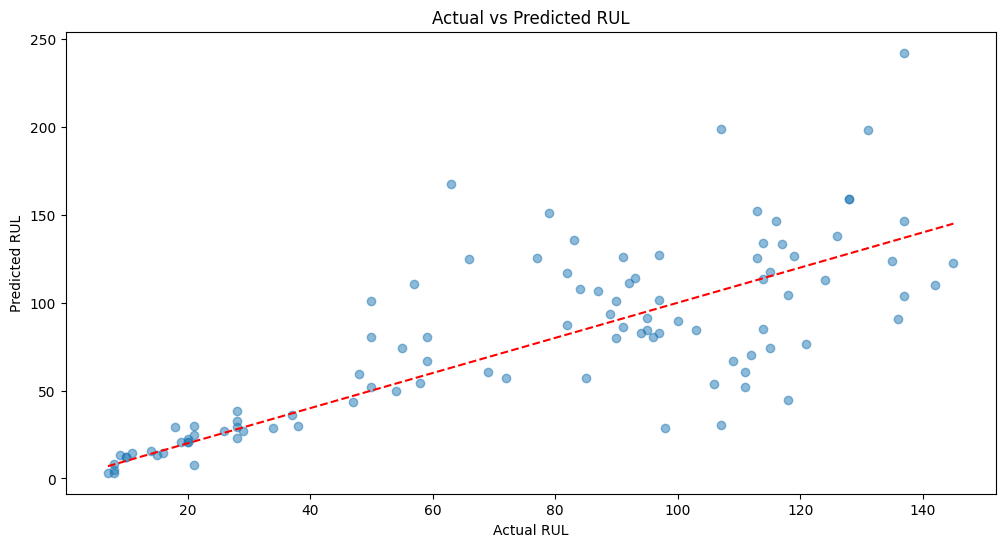

===== 数据检查 =====
引擎ID数量: 100, 实际值数量: 100, 预测值数量: 100
实际值范围: 7.0～145.0
预测值范围: 3.272878646850586～242.25662231445312

===== 绘制简化图表 =====


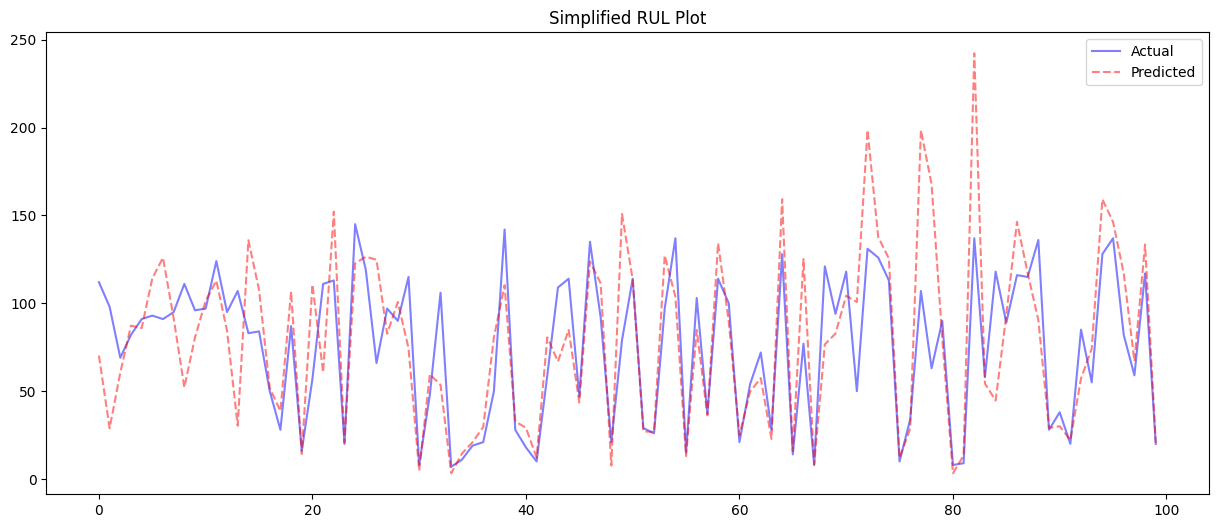

In [12]:
# 加载最佳模型
trained_model.load_state_dict(torch.load(model_path))

model = trained_model

# 测试评估函数
model.eval()
predictions = []
actuals = []
engine_ids = []
    
with torch.no_grad():
    for inputs, labels, ids in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        
        predictions.extend(outputs.cpu().numpy())
        actuals.extend(labels.cpu().numpy())
        engine_ids.extend(ids.cpu().numpy())

predictions = np.array(predictions).flatten()
actuals = np.array(actuals).flatten()
    
    # 计算评估指标
rmse = np.sqrt(mean_squared_error(actuals, predictions))
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)
    
print(f'Test RMSE: {rmse:.4f}')
print(f'Test MAE: {mae:.4f}')
print(f'Test R2 Score: {r2:.4f}')
    
    # 绘制预测结果
plt.figure(figsize=(12, 6))
plt.scatter(actuals, predictions, alpha=0.5)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs Predicted RUL')
plt.show()



# 按引擎ID绘制预测结果

print("===== 数据检查 =====")
print(f"引擎ID数量: {len(engine_ids)}, 实际值数量: {len(actuals)}, 预测值数量: {len(predictions)}")

# 确保使用正确的min/max方法
if isinstance(actuals, list):
    print(f"实际值范围: {min(actuals)}～{max(actuals)}")
else:
    print(f"实际值范围: {actuals.min()}～{actuals.max()}")

if isinstance(predictions, list):
    print(f"预测值范围: {min(predictions)}～{max(predictions)}")
else:
    print(f"预测值范围: {predictions.min()}～{predictions.max()}")

print("\n===== 绘制简化图表 =====")
plt.figure(figsize=(15,6))
plt.plot(actuals, 'b-', alpha=0.5, label='Actual')
plt.plot(predictions, 'r--', alpha=0.5, label='Predicted')
plt.legend()
plt.title('Simplified RUL Plot')
plt.show()

# 保存评估结果
with open(f'models/conv1d_lstm_{dataset}_metrics.txt', 'w') as f:
    f.write(f"RMSE: {rmse:.4f}\n")
    f.write(f"MAE: {mae:.4f}\n")
    f.write(f"R2 Score: {r2:.4f}\n")
